In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-12-17 14:16:47.824347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 14:16:47.855209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 14:16:47.855240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 14:16:47.855268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:16:47.863042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 14:16:47.863920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
DATASET = "mnist"
EMNIST_NUM_CLASSES = 10
EMNIST_IMAGE_SHAPE = (28, 28, 1)

In [3]:
# mnist corresponds to federated emnist(only_digits=True)
train_ds, val_ds = tfds.load('mnist', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('mnist', split='test')
len(train_ds), len(val_ds), len(test_ds)

(48000, 12000, 10000)

2024-12-17 14:16:51.256154: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<matplotlib.image.AxesImage at 0x715d9d54f210>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

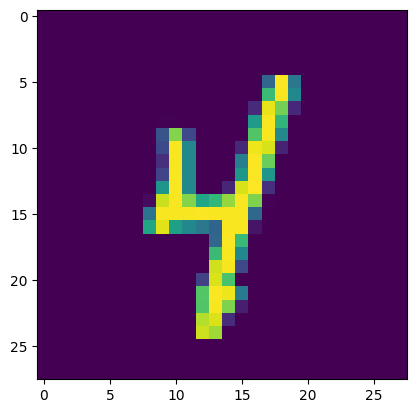

In [4]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [5]:
ex['image'].shape

TensorShape([28, 28, 1])

In [6]:
ex['image'].numpy().max()  # pixels should be scaled down between 0 and 1

255

In [7]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        # image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            .batch(64)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(8)
        )

In [8]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

## Models

In [9]:
from models import get_lucasnet, get_simple_cnn, get_mobilenet, get_efficientnet

In [10]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Simple Convolutional Model

In [11]:
model = get_simple_cnn(EMNIST_IMAGE_SHAPE, EMNIST_NUM_CLASSES)

In [12]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))

Epoch 1/100


 12/750 [..............................] - ETA: 11s - loss: 2.2894 - accuracy: 0.1276

2024-12-17 14:17:02.579132: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22999680 exceeds 10% of free system memory.
2024-12-17 14:17:02.579170: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22999680 exceeds 10% of free system memory.
2024-12-17 14:17:02.597716: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22999680 exceeds 10% of free system memory.
2024-12-17 14:17:02.597756: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22999680 exceeds 10% of free system memory.
2024-12-17 14:17:02.614004: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22999680 exceeds 10% of free system memory.


750/750 [==============================] - 12s 15ms/step - loss: 0.5898 - accuracy: 0.8064 - val_loss: 0.1623 - val_accuracy: 0.9530
Epoch 2/100
750/750 [==============================] - 11s 15ms/step - loss: 0.1978 - accuracy: 0.9399 - val_loss: 0.1075 - val_accuracy: 0.9688
Epoch 3/100
750/750 [==============================] - 11s 14ms/step - loss: 0.1460 - accuracy: 0.9564 - val_loss: 0.0903 - val_accuracy: 0.9740
Epoch 4/100
750/750 [==============================] - 11s 14ms/step - loss: 0.1251 - accuracy: 0.9630 - val_loss: 0.0739 - val_accuracy: 0.9779
Epoch 5/100
750/750 [==============================] - 11s 14ms/step - loss: 0.1097 - accuracy: 0.9669 - val_loss: 0.0646 - val_accuracy: 0.9812
Epoch 6/100
750/750 [==============================] - 11s 14ms/step - loss: 0.0983 - accuracy: 0.9706 - val_loss: 0.0664 - val_accuracy: 0.9818
Epoch 7/100
750/750 [==============================] - 11s 14ms/step - loss: 0.0911 - accuracy: 0.9726 - val_loss: 0.0595 - val_accuracy: 0.98

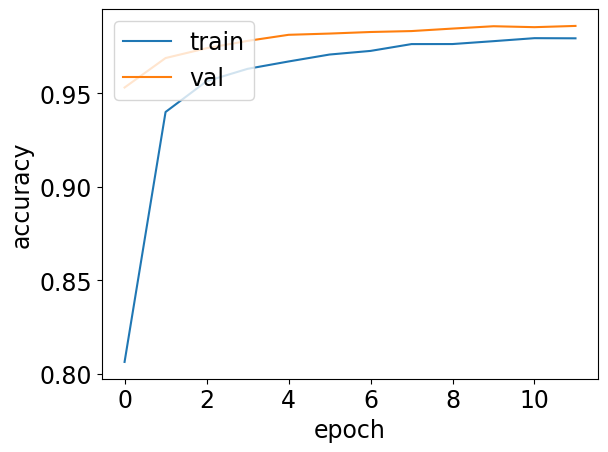

In [18]:
plt.rcParams.update({'font.size': 17})
plot_history(history)

### LL Architecture

In [40]:
model = get_lucasnet(EMNIST_IMAGE_SHAPE, EMNIST_NUM_CLASSES)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8620 - loss: 0.4362 - val_accuracy: 0.9792 - val_loss: 0.0694
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9778 - loss: 0.0767 - val_accuracy: 0.9858 - val_loss: 0.0472
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9841 - loss: 0.0519 - val_accuracy: 0.9877 - val_loss: 0.0405
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9886 - loss: 0.0391 - val_accuracy: 0.9887 - val_loss: 0.0382
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9908 - loss: 0.0293 - val_accuracy: 0.9901 - val_loss: 0.0351
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9920 - loss: 0.0247 - val_accuracy: 0.9893 - val_loss: 0.0346
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9948 - loss: 0.0186 - val_accuracy: 0.9909 - val_loss: 0.0281
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9964 - loss: 0.0142 - val

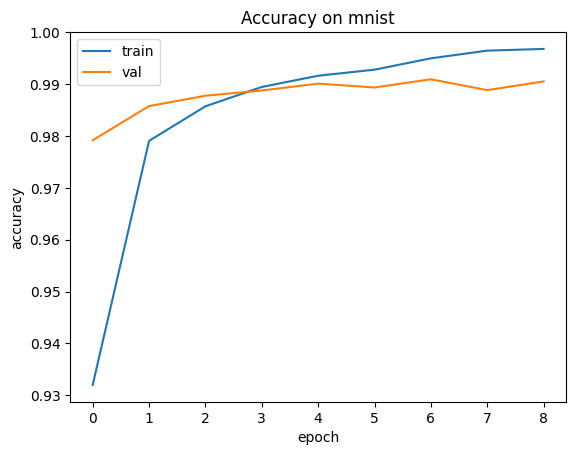

In [41]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### MobileNet

MobileNet doesn't work with the Grayscale shape

### EfficientNet

I didn't see the need to use it as it creates a lot of overhead